In [93]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import classification_report, accuracy_score, mean_squared_error, r2_score
from sklearn.feature_selection import mutual_info_classif
from sklearn.tree import DecisionTreeClassifier

from sklearn.ensemble import RandomForestClassifier

from tabulate import tabulate

In [70]:
df = pd.read_csv('train-4.csv')
df.head()

,id,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed,rainfall
0,0,1,1017.4,21.2,20.6,19.9,19.4,87.0,88.0,1.1,60.0,17.2,1
1,1,2,1019.5,16.2,16.9,15.8,15.4,95.0,91.0,0.0,50.0,21.9,1
2,2,3,1024.1,19.4,16.1,14.6,9.3,75.0,47.0,8.3,70.0,18.1,1
3,3,4,1013.4,18.1,17.8,16.9,16.8,95.0,95.0,0.0,60.0,35.6,1
4,4,5,1021.8,21.3,18.4,15.2,9.6,52.0,45.0,3.6,40.0,24.8,0


# Data Preprocessing - handling missing values, dropping irrelevant columns, scaling, etc.

In [71]:
df.drop(['id'], axis=1, inplace=True)
df.drop(['day'], axis=1, inplace=True)

In [72]:
for col in df.columns:
    if df[col].isnull().any():
        if df[col].dtype == 'object':
            df[col].fillna(df[col].mode()[0], inplace=True)
        else:
            df[col].fillna(df[col].mean(), inplace=True)
df.isnull().sum()

pressure         0
maxtemp          0
temparature      0
mintemp          0
dewpoint         0
humidity         0
cloud            0
sunshine         0
winddirection    0
windspeed        0
rainfall         0
dtype: int64

In [73]:
df.isnull().sum()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2190 entries, 0 to 2189
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   pressure       2190 non-null   float64
 1   maxtemp        2190 non-null   float64
 2   temparature    2190 non-null   float64
 3   mintemp        2190 non-null   float64
 4   dewpoint       2190 non-null   float64
 5   humidity       2190 non-null   float64
 6   cloud          2190 non-null   float64
 7   sunshine       2190 non-null   float64
 8   winddirection  2190 non-null   float64
 9   windspeed      2190 non-null   float64
 10  rainfall       2190 non-null   int64  
dtypes: float64(10), int64(1)
memory usage: 188.3 KB


# scaling

In [74]:
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df != 'rainfall')

In [75]:
num_cols = df.select_dtypes(include='number').columns
skewness = df[num_cols].skew().sort_values(ascending=False)
print(skewness)

windspeed        0.769390
winddirection    0.708063
sunshine         0.639871
pressure         0.284062
maxtemp         -0.490890
temparature     -0.557471
humidity        -0.561541
mintemp         -0.649179
dewpoint        -0.997889
rainfall        -1.176743
cloud           -1.339274
dtype: float64


In [76]:
df.head()

,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed,rainfall
0,1017.4,21.2,20.6,19.9,19.4,87.0,88.0,1.1,60.0,17.2,1
1,1019.5,16.2,16.9,15.8,15.4,95.0,91.0,0.0,50.0,21.9,1
2,1024.1,19.4,16.1,14.6,9.3,75.0,47.0,8.3,70.0,18.1,1
3,1013.4,18.1,17.8,16.9,16.8,95.0,95.0,0.0,60.0,35.6,1
4,1021.8,21.3,18.4,15.2,9.6,52.0,45.0,3.6,40.0,24.8,0


In [77]:
for col in num_cols:
  if 0.5 < skewness[col] < 1 or -1 < skewness[col] < -0.5:
    df[col] = np.power(df[col], 1/2)
  elif -2 < skewness[col] < -1 or 1 < skewness[col] < 2:
    df[col] = np.power(df[col], 2)

skewness_new = df[num_cols].skew().sort_values(ascending=False)
print(skewness_new)

winddirection    0.384804
pressure         0.284062
windspeed        0.279546
sunshine        -0.002138
maxtemp         -0.490890
temparature     -0.734331
humidity        -0.831225
cloud           -0.857183
mintemp         -0.885308
rainfall        -1.176743
dewpoint        -1.567924
dtype: float64


# Data Visualization

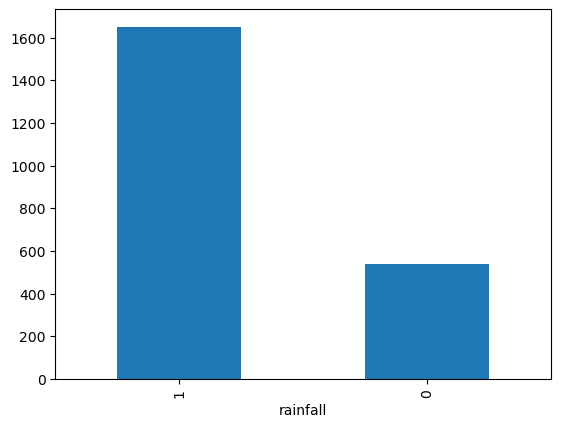

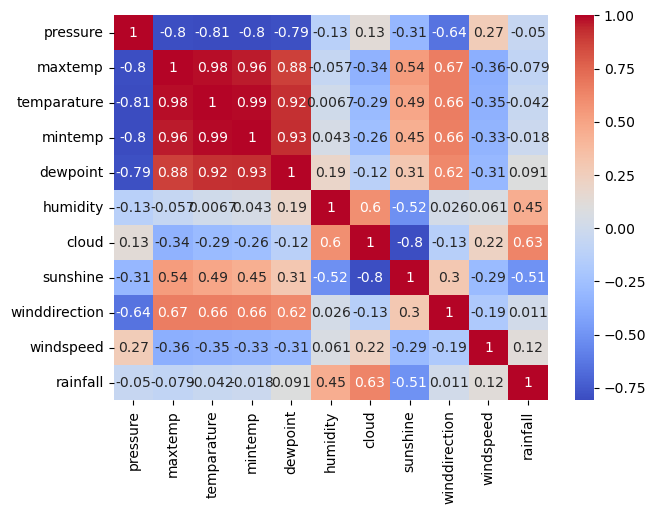

In [85]:
# show rainfall value counts with bar plot
df['rainfall'].value_counts().plot(kind='bar')
plt.show()
# show correlation matrix with heatmap
plt.figure(figsize=(7, 5))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.show()


# Model Selection

In [33]:
x = df.drop(columns=['rainfall'])
y = df['rainfall']

x_train, x_temp, y_train, y_temp = train_test_split(x, y, test_size=0.2, random_state=42)
x_test, x_val, y_test, y_val = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42)

In [34]:
x_train.shape, y_train.shape

((1752, 10), (1752,))

In [35]:
x_val.shape, y_val.shape

((219, 10), (219,))

# Decision Tree Classifier

In [40]:
dt = DecisionTreeClassifier()
dt.fit(x_train, y_train)


DecisionTreeClassifier()

In [104]:
y_pred = dt.predict(x_val)
cr_report = classification_report(y_val, y_pred)
print(classification_report(y_val, y_pred))
ac_score = accuracy_score(y_val, y_pred)
print('accuracy score: ', accuracy_score(y_val, y_pred))


              precision    recall  f1-score   support

           0       0.58      0.52      0.55        63
           1       0.81      0.85      0.83       156

    accuracy                           0.75       219
   macro avg       0.70      0.68      0.69       219
weighted avg       0.75      0.75      0.75       219

accuracy score:  0.7534246575342466


# Random Forest Classifier

In [95]:
rf = RandomForestClassifier()
rf.fit(x_train, y_train)

RandomForestClassifier()

In [105]:
y_pred = rf.predict(x_val)
cr_report1 = classification_report(y_val, y_pred)
print(cr_report1)
ac_score1 = accuracy_score(y_val, y_pred)
print('accuracy score: ', accuracy_score(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.77      0.59      0.67        63
           1       0.85      0.93      0.89       156

    accuracy                           0.83       219
   macro avg       0.81      0.76      0.78       219
weighted avg       0.83      0.83      0.82       219

accuracy score:  0.8310502283105022


In [108]:

data = [
  ["Decision Tree Classifier", ac_score],
  ["Random Forest Classifier", ac_score1]
]


headers = ['Model', 'accuracy score']

In [109]:
	
table = tabulate(data, headers, tablefmt='grid')
print(table)

+--------------------------+------------------+
| Model                    |   accuracy score |
+==========================+==================+
| Decision Tree Classifier |         0.753425 |
+--------------------------+------------------+
| Random Forest Classifier |         0.83105  |
+--------------------------+------------------+
